<a href="https://colab.research.google.com/github/ThatCodeCodingGuy/Toxic-Comment-Detector/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Necessary Packages and Modules**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics, svm
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gauri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gauri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gauri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Glancing at the data**

In [7]:
df = pd.read_csv('toxicity.csv')

In [8]:
df.head()

,text,is_toxic
0,"Elon Musk is a piece of shit, greedy capitalis...",Toxic
1,The senile credit card shrill from Delaware ne...,Toxic
2,He does that a lot -- makes everyone look good...,Toxic
3,F*ck Lizzo,Toxic
4,Epstein and trump were best buds!!! Pedophiles...,Toxic


In [9]:
df.groupby('text').count()

,is_toxic
text,
""" Amazing Humans""????Not in my book( Pun intended) this is terrible,you do NOT confuse infants that ""Drag Queens"" are the norm, absolutely sickening that these people are allowed to do this kind of propaganda to infants and children!!",1
"""Guns don't kill people....Alec Baldwin does.""",1
"""How to correctly hit a #woman"" #feminism #islam #terrorist",1
"""I am asking you in a very educated manner"" bitch get out of the fucking car",1
"""I'm a full on rapist... I mean a philanthropist"" \n \n -Bill Gates",1
...,...
"{nods in agreement} Stay in school and keep practicing, kids",1
"“Bitch, you ain’t takin SHIT, but’choo can DAMN sure take it up with me right here and now”. \n But see, I don’t have anxiety, and my dog weighs 122 pounds, so . . . . . .",1
"“You Trumpsters better pray that liberals never gain control of the WH again because we are going to pay you back so fucking hard for all of this shit. Planned Parenthoods on every damn corner. We're going to repaint Air Force One, pussy hat pink and fly it over your beloved Bible Belt 6 days a week, tossing birth control pills, condoms & atheist literature from the cockpit. We're going to tax your mega churches so bad Joel Olsteen will need to get a job at Chik Fil A to pay his light bill. Speaking of Chik Fil A, we're buying all those and giving them to any LGBTQ person your sick cult leaders tortured with conversion therapy. Have fun with the new menu you bigoted fucks. Try the McPence. It's a boiled unseasoned chicken breast that you have to eat in the closet with your mother. We’re going to gather up ALL of your guns, melt them down and turn them into a gargantuan metal mountain emblazoned with the face of Hillary Clinton. ALL parks will be renamed Rosa Parks asap. We're replacing Confederate statues with BLM Leaders & Mexican immigrants. Every single public school will be renamed after a child that was kidnapped by this regime. And after we fumigate the WH, we're repainting the whole thing rainbow. Fox News will be taken over and turned into a family refugee shelter. We're turning Hannity's office into a giant unisex bathroom with changing tables & free tampons. And every single time a Trumpster complains about any of the changes, we're adding an openly gay character to a Disney movie.""",1


<AxesSubplot:>

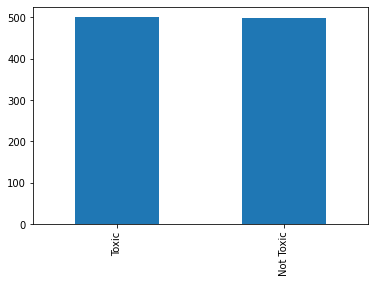

In [10]:
df['is_toxic'].value_counts().plot(kind='bar')

# **Cleaning the Text**

In [11]:
def clean_text(text):
    # make text lowercase
    text = text.lower()
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # getting rid of punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text

clean = lambda x: clean_text(x)

In [12]:
df['clean_text'] = df['text'].apply(clean)

In [13]:
df.head()

,text,is_toxic,clean_text
0,"Elon Musk is a piece of shit, greedy capitalis...",Toxic,elon musk is a piece of shit greedy capitalist...
1,The senile credit card shrill from Delaware ne...,Toxic,the senile credit card shrill from delaware ne...
2,He does that a lot -- makes everyone look good...,Toxic,he does that a lot makes everyone look good b...
3,F*ck Lizzo,Toxic,fck lizzo
4,Epstein and trump were best buds!!! Pedophiles...,Toxic,epstein and trump were best buds pedophiles wh...


In [14]:
text_df = df[['clean_text', 'is_toxic']].copy()

In [15]:
text_df.head()

,clean_text,is_toxic
0,elon musk is a piece of shit greedy capitalist...,Toxic
1,the senile credit card shrill from delaware ne...,Toxic
2,he does that a lot makes everyone look good b...,Toxic
3,fck lizzo,Toxic
4,epstein and trump were best buds pedophiles wh...,Toxic


In [16]:
text_df['is_toxic'] = text_df['is_toxic'].replace('Toxic', 1)
text_df['is_toxic'] = text_df['is_toxic'].replace('Not Toxic', 0)

In [17]:
text_df.head()

,clean_text,is_toxic
0,elon musk is a piece of shit greedy capitalist...,1
1,the senile credit card shrill from delaware ne...,1
2,he does that a lot makes everyone look good b...,1
3,fck lizzo,1
4,epstein and trump were best buds pedophiles wh...,1


In [18]:
data = text_df['clean_text']
target = text_df['is_toxic']

# Looking at the most frequent words of unclean and clean versions of the data 

*Unclean Data*

In [19]:
# looking at the unclean data
def unfiltered_tokens(text):
    dirty_tokens = nltk.word_tokenize(text)
    return dirty_tokens

In [20]:
# applying this function to the `clean_text` column
unfiltered_data = list(map(unfiltered_tokens, data))

In [21]:
# turning this into a readable list and getting most frequent 20 words
flat_unfiltered = [item for sublist in unfiltered_data for item in sublist]
dirty_corpus_freqdist = FreqDist(flat_unfiltered)
dirty_corpus_freqdist.most_common(20)

[('the', 916),
 ('and', 594),
 ('a', 590),
 ('to', 538),
 ('i', 477),
 ('of', 399),
 ('you', 394),
 ('is', 376),
 ('that', 299),
 ('in', 285),
 ('it', 284),
 ('for', 235),
 ('’', 230),
 ('this', 229),
 ('are', 184),
 ('he', 166),
 ('be', 158),
 ('with', 154),
 ('on', 141),
 ('your', 139)]

*Clean Data*

In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
def process_text(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed 

In [24]:
# applying the above function to our data/features 
processed_data = list(map(process_text, data))

In [25]:
total_vocab = set()
for comment in processed_data:
    total_vocab.update(comment)
len(total_vocab)

5047

In [26]:
# turning the data into a readable list and getting top 20 words
flat_filtered = [item for sublist in processed_data for item in sublist]
clean_corpus_freqdist = FreqDist(flat_filtered)
clean_corpus_freqdist.most_common(20)

[('’', 230),
 ('like', 123),
 ('people', 85),
 ('get', 74),
 ('good', 68),
 ('would', 63),
 ('go', 61),
 ('im', 52),
 ('see', 51),
 ('love', 50),
 ('never', 48),
 ('one', 47),
 ('know', 46),
 ('dont', 46),
 ('biden', 45),
 ('really', 44),
 ('time', 42),
 ('think', 42),
 ('way', 40),
 ('joe', 39)]

# **Lemmatization**

In [27]:
# creating a list with all lemmatized outputs
lemmatizer = WordNetLemmatizer() 
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [28]:
X_lem = lemmatized_output
y_lem = target

# **Splitting the dataset into Train-Test and Vectorization**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

# using tf_idf vectorizor with bigrams
tfidf = TfidfVectorizer(stop_words= stop_words, ngram_range=(1,2))

In [30]:
tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

# **Modeling: SVM, Logistic Regression and Multinomial Naive Bayes**

# **SVM**

In [31]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced', random_state=20)

In [32]:
# fitting the dataset to the model and predicting the labels on validation dataset
%%time 
SVM.fit(tfidf_data_train, y_train)
SVM_test_preds = SVM.predict(tfidf_data_test)

UsageError: Line magic function `%%time` not found.


In [33]:
# measuring the performance fo the model by several metrics
SVM_precision = precision_score(y_test, SVM_test_preds)
SVM_recall = recall_score(y_test, SVM_test_preds)
SVM_f1_score = f1_score(y_test, SVM_test_preds)
SVM_weighted_f1_score = f1_score(y_test, SVM_test_preds, average='weighted')

NameError: name 'SVM_test_preds' is not defined

In [ ]:
# printing evaluation metrics up to 4th decimal place
print('Precision: {:.4}'.format(SVM_precision))
print('Recall: {:.4}'.format(SVM_recall))
print('F1 Score: {:.4}'.format(SVM_f1_score))
print('Weighted F1 Score: {:.4}'.format(SVM_weighted_f1_score))

Precision: 0.8218
Recall: 0.83
F1 Score: 0.8259
Weighted F1 Score: 0.825


In [ ]:
# creating dictionary with all metrics
metric_dict = {}
metric_dict['SVM'] = {'precision': SVM_precision, 'recall': SVM_recall, 'f1_score': SVM_f1_score}

# **Logistic Regression**

In [ ]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [ ]:
%%time
logreg_baseline.fit(tfidf_data_train, y_train)
logreg_test_preds = logreg_baseline.predict(tfidf_data_test)

CPU times: user 77.6 ms, sys: 109 ms, total: 187 ms
Wall time: 112 ms


In [ ]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_weighted_f1_score = f1_score(y_test, logreg_test_preds, average='weighted')

In [ ]:
print('Precision: {:.4}'.format(logreg_precision))
print('Recall: {:.4}'.format(logreg_recall))
print('F1 Score: {:.4}'.format(logreg_f1_score))

Precision: 0.8163
Recall: 0.8
F1 Score: 0.8081


In [ ]:
metric_dict['Logistic Regression'] = {'precision': logreg_precision, 'recall': logreg_recall, 'f1_score': logreg_f1_score}

# **Multinomial Naive Bayes**

In [ ]:
bayes = MultinomialNB(alpha = .01)

In [ ]:
bayes.fit(tfidf_data_train, y_train)
bayes_test_preds = bayes.predict(tfidf_data_test)

In [ ]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

In [ ]:
print('Precision: {:.4}'.format(bayes_precision))
print('Recall: {:.4}'.format(bayes_recall))
print('F1 Score: {:.4}'.format(bayes_f1_score))

Precision: 0.8148
Recall: 0.88
F1 Score: 0.8462


In [ ]:
metric_dict[ 'Naive Bayes'] = {'precision': bayes_precision, 'recall': bayes_recall, 'f1_score': bayes_f1_score}

# **Comparison of the results**

In [ ]:
pd.DataFrame.from_dict(metric_dict, orient='index')

,precision,recall,f1_score
SVM,0.821782,0.83,0.825871
Logistic Regression,0.816327,0.80,0.808081
Naive Bayes,0.814815,0.88,0.846154


# **Pickling necessary features for later use**

In [ ]:
import pickle 
pickle_out = open("X_train.pickel", "wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("final_bayes.pickel", "wb")
pickle.dump(bayes, pickle_out)
pickle_out.close()